In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

device = torch.device('cuda:1')
device_id =0
batch_size = 128
path = r'../1D data/1Ddata_200000.pkl'
# Read the CSV file into a DataFrame
df = pd.read_pickle(path)
df

/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,p0_z,Stored_Soln,Filename,assignment
0,"[0.0013078730259690483, 5.767715166845944e-05,...","[99.81197634406357, 99.9051808775484, 100.1820...",SSE_scenario_Simple_41.mat,training
1,"[0.0010566353101015427, 0.0181349470794876, 0....","[3.3751528998258227, 3.958544413082805, 4.8162...",SSE_scenario_Simple_41.mat,training
2,"[0.0013694484308627703, 2.0181875596728656e-05...","[0.018987040600910794, 0.022747528330281503, 0...",SSE_scenario_Simple_41.mat,training
3,"[0.6668054180744276, 2.918248867198086e-05, 0....","[0.0027451260001320624, 0.0034260012139897783,...",SSE_scenario_Simple_41.mat,training
4,"[0.0005887946427166038, 2.5585979053718797e-05...","[0.01733281694241302, 0.017942268542110354, 0....",SSE_scenario_Simple_41.mat,training
...,...,...,...,...
199995,"[0.09196335739072944, 7.403282931096018e-05, 5...","[0.002709440089430276, 0.003270194045325576, 0...",SSE_scenario_Simple_63.mat,training
199996,"[0.0003295054402272515, 3.678602218397147e-05,...","[0.0031435006896547014, 0.0036774661176829154,...",SSE_scenario_Simple_63.mat,training
199997,"[0.00041013144165523386, 0.04102778447056471, ...","[67.19886192601444, 82.34184784930989, 101.534...",SSE_scenario_Simple_63.mat,training
199998,"[0.10506428450176938, 0.0016908735887324155, 0...","[3.5304451302054813, 6.405956350973893, 19.430...",SSE_scenario_Simple_63.mat,training


/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
  This is separate from the ipykernel package so we can avoid doing imports until


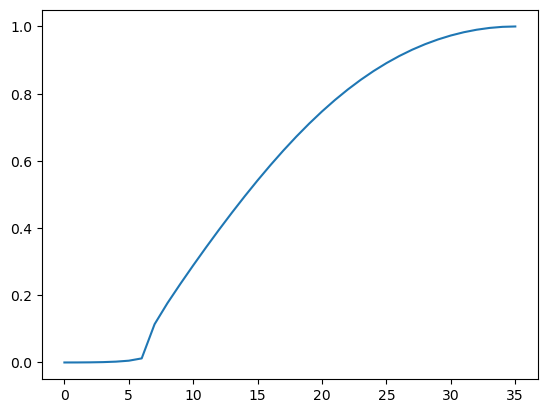

In [2]:
import matplotlib.pyplot as plt
def normalized_data(data):
    data = torch.FloatTensor(data)
    data[data<1e-8]=1e-8
    data = torch.log10(data)
    data /=8 
    return data

#make dataloadr
train_df = df[df['assignment'] == 'training']
valid_df = df[df['assignment'] == 'validation']
test_df = df[df['assignment'] == 'test']


input_pz = normalized_data(train_df['p0_z']).clone()
#output_soln = normalized_data(train_df['Stored_Soln']).clone()################################
output_soln = torch.FloatTensor(train_df['Stored_Soln'])
data_min = torch.min(output_soln, dim=1, keepdim=True).values
data_max = torch.max(output_soln, dim=1, keepdim=True).values


output_soln = (output_soln - data_min) / (data_max - data_min)

output_soln[:,0:36].shape
plt.plot(output_soln[999,0:36])
out = output_soln[:,0:36]





In [3]:
print(out.shape)

torch.Size([144000, 36])


In [4]:
import numpy as np
from annoy import AnnoyIndex
import matplotlib.pyplot as plt

DIMENSIONS = 36
def build_annoy_index(data, n_trees=5):
    t = AnnoyIndex(DIMENSIONS, 'euclidean')  
    for i, item in enumerate(data):
        t.add_item(i, item)
    t.build(n_trees)
    
    return t

def find_similar_pairs(index, data, n_neighbors=2):
    similar_pairs = []
    
    for i, item in enumerate(data):
        neighbors = index.get_nns_by_item(i, n_neighbors)
        for neighbor in neighbors[1:]:
            similar_pairs.append((i, neighbor))
            
    return similar_pairs


index = build_annoy_index(out)
pairs = find_similar_pairs(index, out)


def get_delete_indices(pairs):
    occurrence_dict = {}

    for i, j in pairs:
        if i not in occurrence_dict:
            occurrence_dict[i] = {'seen': True, 'has_similar': True}
        if j not in occurrence_dict:
            occurrence_dict[j] = {'seen': False, 'has_similar': True}
    delete_indices = [index for index, value in occurrence_dict.items() if not (value['seen'] or not value['has_similar'])]
    return delete_indices

indices_to_delete = get_delete_indices(pairs)
mask = torch.ones(out.size(0), dtype=torch.bool)
mask[indices_to_delete] = False
filtered_output = out[mask]
filtered_input = input_pz[mask]
print('Done')

Done


In [5]:
print(filtered_output.shape)
print(filtered_input.shape)

torch.Size([88412, 36])
torch.Size([88412, 11])


In [6]:
class CDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input_pz = normalized_data(self.dataframe.iloc[idx]['p0_z']).clone()
        output_soln = torch.FloatTensor(self.dataframe.iloc[idx]['Stored_Soln']).clone()
        output_soln = output_soln[0:36]
        output_soln = (output_soln - output_soln.min()) / (output_soln.max() - output_soln.min())
        return input_pz, output_soln
    
class input_set(Dataset):
    def __init__(self, input, output):
        self.input = input
        self.output = output

    def __len__(self):
        return self.input.shape[0]

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

train_dataset = input_set(filtered_input, filtered_output)
validate_dataset = CDataset(valid_df)
test_dataset = CDataset(test_df)
print(len(train_dataset))
print(len(validate_dataset))
print(len(test_dataset))

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

88412
22000
34000


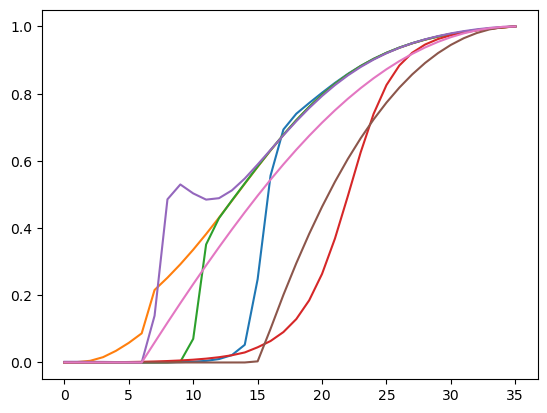

In [7]:
t = iter(training_dataloader)
x, y = next(t)
y[0]
plt.plot(y[0])
plt.plot(y[1])
plt.plot(y[2])
plt.plot(y[3])
plt.plot(y[4])
plt.plot(y[5])
plt.plot(y[6])
plt.show()

In [8]:
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom


# ndim_tot = 36
# def subnet_fc(c_in, c_out):
#     return nn.Sequential(nn.Linear(c_in, 128), nn.LeakyReLU(),nn.Linear(128, 256), nn.LeakyReLU(),
#                          nn.Linear(256,  c_out))

# nodes = [InputNode(ndim_tot, name='input')]

# for k in range(56):
#     nodes.append(Node(nodes[-1],
#                       GLOWCouplingBlock,
#                       {'subnet_constructor':subnet_fc, 'clamp':2},
#                       name=F'coupling_{k}'))
#     nodes.append(Node(nodes[-1],
#                       PermuteRandom,
#                       {'seed':k},
#                       name=F'permute_{k}'))


ndim_tot = 36
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(), nn.Linear(512, 1024), nn.ReLU(),nn.Linear(1024, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(15):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':1},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))
    
nodes.append(OutputNode(nodes[-1], name='output'))
INN_model = ReversibleGraphNet(nodes, verbose=False).to(device)

class MyModel(nn.Module):
    def __init__(self, INN):
        super(MyModel, self).__init__()
        self.reversible_part = INN
        
    def forward(self, x):
        x, log_jac_det  = self.reversible_part(x)
        return x, log_jac_det


    def invert_model(self, final_output):
        x_reverse = self.reversible_part(final_output, rev = True)[0]
        return x_reverse

In [9]:
model_name = '1D_modeINN_new.pth'
        


def test(test_loader, model):
    mean_loss = 0
    model.eval()    
    total_loss = 0.0
    total_ssres = 0
    total_data_points = 0
    mean_ssres = 0
    model = model.to(device)
    with torch.no_grad():
        for inputs, target in tqdm(test_loader):
            # measure data loading time    
            target = target.to(device)
            output, _= model(target.float().to(device))
            inputs = inputs.to(device)
            loss = F.mse_loss(output[:, :11], inputs, reduction='sum')
            ssres = (output[:, :11] - inputs).pow(2).sum()

            total_loss += loss.item() 
            total_ssres += ssres.item()
            total_data_points += len(inputs)
    avg_mse_loss = total_loss / total_data_points
    ave_ssre_loss = total_ssres / total_data_points
    return avg_mse_loss, ave_ssre_loss
    


print("***********************************************")
print("test procedure")
model = MyModel(INN_model)
model.load_state_dict(torch.load(model_name, map_location=device))
avg_mse_loss, ave_ssre_loss = test(test_dataloader, model)
print(f"Average MSE Loss on Test Set: {avg_mse_loss}")
avg_mse_loss, ave_ssre_loss = test(training_dataloader, model)
print(f"Average MSE Loss on Training Set: {avg_mse_loss}")


***********************************************
test procedure


100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [00:12<00:00, 21.50it/s]


Average MSE Loss on Test Set: 0.14250658346624936


100%|█████████████████████████████████████████████████████████████████████████████████| 691/691 [00:11<00:00, 57.81it/s]

Average MSE Loss on Training Set: 0.11616500742224144


In [10]:
#forward
test_sample = test_dataset[23295]
model  = MyModel(INN_model).to(device)
model.load_state_dict(torch.load(model_name, map_location=device))
model = model.eval()
guest_input,_ = model(test_sample[1].unsqueeze(0).to(device))
print('forward_linear', guest_input[:,:11])
guest_input = guest_input[:,:11]

forward_linear tensor([[-0.2159, -0.2581, -0.6131, -0.3689, -0.1359,  0.2409,  0.1225, -0.4739,
         -0.4444, -0.1422, -0.1466]], device='cuda:1',
       grad_fn=<SliceBackward0>)


In [11]:
# reverse
test_sample_input = F.pad(test_sample[0], (0, 25), 'constant', 0)
INN_predict_input = model.invert_model(test_sample_input.unsqueeze(0).to(device))
INN_predict_input

tensor([[1.0769e-05, 3.0451e-04, 7.8864e-04, 1.4803e-03, 2.8352e-03, 4.7920e-03,
         6.6857e-03, 1.0491e-02, 1.4508e-02, 1.8720e-02, 2.6057e-02, 3.6256e-02,
         4.8772e-02, 6.9981e-02, 9.3193e-02, 1.9257e-01, 2.6260e-01, 3.3593e-01,
         4.0708e-01, 4.8307e-01, 5.4756e-01, 6.1072e-01, 6.6961e-01, 7.2520e-01,
         7.7343e-01, 8.1668e-01, 8.5297e-01, 8.8624e-01, 9.1089e-01, 9.3346e-01,
         9.5344e-01, 9.6779e-01, 9.8066e-01, 9.8635e-01, 9.9126e-01, 9.9684e-01]],
       device='cuda:1', grad_fn=<CatBackward0>)

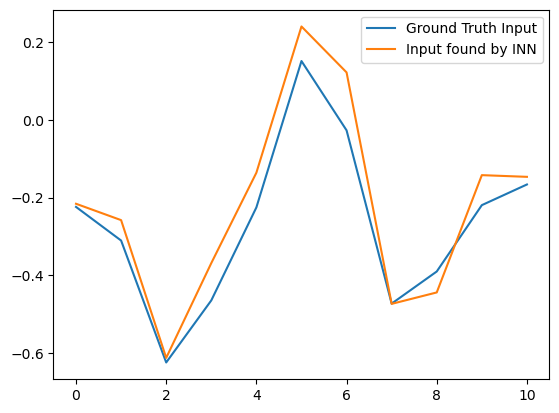

In [12]:
plt.plot(test_sample[0], label ="Ground Truth Input")
plt.plot(guest_input.squeeze().detach().cpu().numpy(), label ="Input found by INN")
plt.legend()
plt.show()

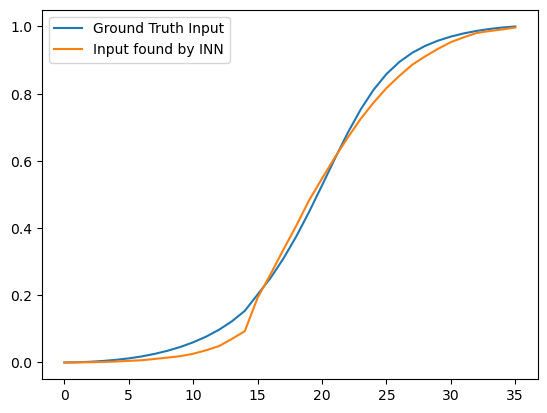

In [13]:
# backward test
plt.plot(test_sample[1], label ="Ground Truth Input")
plt.plot(INN_predict_input.squeeze().detach().cpu().numpy(), label ="Input found by INN")
plt.legend()
plt.show()

In [14]:
test_sample[1].shape

torch.Size([36])

In [15]:
#test code
import scipy.io
import os
import pandas as pd

directory_path = r'../1D data/experData.mat'
data = scipy.io.loadmat(directory_path)
ce = data['experData'][0][0]
test_out = ce["y"][0][0]
#test_output = normalized_data(test_out)
test_output = torch.tensor(test_out).float()

min_val = test_output.min(dim=1, keepdim=True).values
max_val = test_output.max(dim=1, keepdim=True).values

normalized_tensor = (test_output - min_val) / (max_val - min_val)

test_output = normalized_tensor
print(test_output.shape)
inference,_ = model(test_output.to(device))
finding = inference[:,0:11]

torch.Size([1, 36])


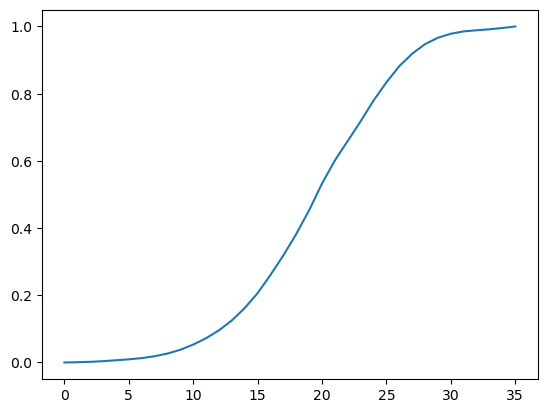

In [16]:
plt.plot(test_output[0], label ="Ground Truth Input")
plt.show()

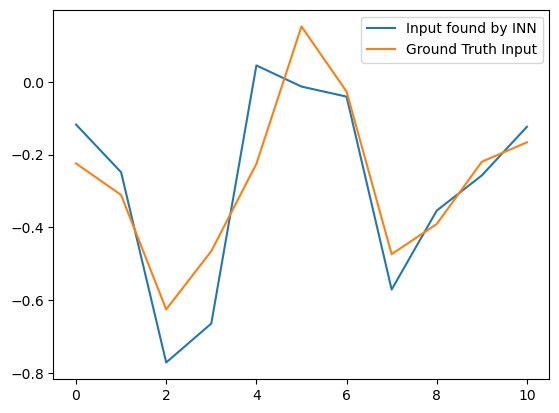

In [17]:
plt.plot(finding.squeeze().detach().cpu().numpy(), label ="Input found by INN")
plt.plot(test_sample[0], label ="Ground Truth Input")
plt.legend()
plt.show()


In [18]:
def denormalized_data(data):
    data = data*8
    data = 10**(data)
    return data

In [19]:
test = denormalized_data(finding)
test

tensor([[1.1536e-01, 1.0307e-02, 6.8453e-07, 4.9025e-06, 2.2865e+00, 7.8500e-01,
         4.7198e-01, 2.7335e-05, 1.4805e-03, 8.7887e-03, 1.0274e-01]],
       device='cuda:1', grad_fn=<PowBackward1>)